# PT1 parameter Analysis
### Structure
* Imports
    * Libraries: necessary Python Libraries
    * MAT data imports: Importing the estimated from the files generated in MATLAB.
* Calculations
    * Accuracy Metric: Measures how well the estimated PT1 model fits the real data 
* Filtering: Filtering out parameter outliers
* Representation: Visualized the data for analysis
### Attention:
* Make sure to change all of the paths in the file (in the Runnables) so it can run on your system.
    * Default saves to: "C:/git/kdp_hlb_evalframework/_temp/"

# Imports

## Libraries

In [1]:
import pandas as pd
import os
import json
import math
import numpy as np
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

## MAT data

### Methods

* get_speedup_reason(trip_name, speedup_index)
    * Extracts the driving event reason list from the info json file corresponding to a trip
    * Inputs: 
        * trip_name (string) -- name of the trip that is analyzed e.g. "14_20210719_1626665410733632_CT6_AVT_V3_export" 
        * speedup_index (int) -- index of the speedup in the trip (trip has multiple speedups, this tells us which one it is)
    * Outputs:
        * returns a list containing the driving event reasons extracted in "driving_event_metadata_analysis.py"
* speedup_length_filter(trip_name, speedup_index)
    * Filters out extracted speedup that are too long in terms of time 
    * Inputs: 
        * trip_name (string) -- name of the trip that is analyzed e.g. "14_20210719_1626665410733632_CT6_AVT_V3_export" 
        * speedup_index (int) -- index of the speedup in the trip (trip has multiple speedups, this tells us which one it is)
    * Outputs:
        * returns False if the speedup is too long to be analyzed for the PT1 model
        * returns True otherwise
* get_speedup_parameters(start, end, mat_dict, df)
    * Extracts the PT1 parameters out of the MAT file crated during the MATLAB parameter estimation.
    * Inputs:
        * start (int) -- index of the first trip in trip_info that is analyzed
        * end (int) -- index of the last trip in trip_info that is analyzed
        * mat_dict (dictionary) -- The MAT file where the PT1 parameters are saved as a dictionary
        * trip_infos (pandas DataFrame) -- maps the trip_name to the driver_id, includes information about how many speedups a trip has and serves as an overview of all the speedups whose parameters can be estimated.
    * Outputs:
        * speedup_parameters (numpy array) -- parameters [K, Tp1] for all speedups
        * parameters_df (pandas DataFrame): The DataFrame has several columns
            * "trip_name" (string) -- name of the trip that is analyzed
            * "speedup_index" (int) -- index of the speedup that is analyzed within the trip
            * "driver_id" (string) -- name of the driver specified in "ArchiveCheck_update.csv"
            * "velocity_class" (string) -- velocity category extracted as a driving event reason during the Metadata analysis. Possible Categories are:
                * "zero_to_low_speed_up"
                * "zero_to_mid_speed_up"
                * "zero_to_high_speed_up",
                * "low_to_low_speed_up"
                * "low_to_mid_speed_up"
                * "low_to_high_speed_up",
                * "mid_to_mid_speed_up"
                * "mid_to_high_speed_up"
                * "high_to_high_speed_up",
            * "highway_driving" (boolean) -- whether or not any section during the speedup time sequence had a "highway" signal active.
            * "K" (float) -- Control Gain of the transfer function of the PT1 model
            * "Tp1" (float) --  pole of the transfer function of the PT1 model

In [2]:
def get_speedup_reason(trip_name, speedup_index):
    info_path = "C:/git/kdp_hlb_evalframework/_temp/driving_event_window_info/" + trip_name + "_info.json"
    with open(info_path, 'r') as open_file:
        read_list = json.load(open_file)
    for window_dict in read_list:
        if window_dict['data'] == 'speed_up'+str(speedup_index)+'.csv':
            return window_dict['driving_event_reason']

In [3]:
def speedup_length_filter(trip_name, speedup_index):
    MAX_SPEEDUP_LENGTH = 750
    info_path = "C:/git/kdp_hlb_evalframework/_temp/driving_event_window_info/" + trip_name + "_info.json"
    with open(info_path, 'r') as open_file:
        read_list = json.load(open_file)
    for window_dict in read_list:
        if window_dict['data'] == 'speed_up'+str(speedup_index)+'.csv':
            length = int(window_dict['length'])
            if length > MAX_SPEEDUP_LENGTH:
                return False
            else:
                return True

In [4]:
def get_speedup_parameters(start, end, mat_dict, df):
    y = []
    parameters_df = pd.DataFrame(columns=["trip_name", "speedup_index", "driver_id", "velocity_class", "highway_driving","K", "Tp1"])
    velocity_classes = ["zero_to_low_speed_up", "zero_to_mid_speed_up", "zero_to_high_speed_up",
                "low_to_low_speed_up", "low_to_mid_speed_up", "low_to_high_speed_up",
                "mid_to_mid_speed_up", "mid_to_high_speed_up", "high_to_high_speed_up",
                ]
    end = min(end, df.shape[0])
    for i in range(start, end):
        number_of_speedups = df['number_of_speedups'][i]
        trip_name = df['trip_name'][i]
        driver_id = df['subject_id'][i]
        for j in range(number_of_speedups-1):
            parameter_string = "trip{index}_speedup_{speedup_index}_parameter".format(index = i, speedup_index = j)
            parameters = mat_dict[parameter_string][0]
            reasons = get_speedup_reason(trip_name=trip_name, speedup_index=j)
            velocity_class = "unknown"
            highway_driving = False
            for reason in reasons:
                if reason in velocity_classes:
                    velocity_class = reason 
            if "highway_driving" in reasons:
                highway_driving = True
            #parameters are [K, w0, D]
            if not "turn" in reasons:
                y.append(parameters)
                parameters_df.loc[-1] = [trip_name, j, driver_id, velocity_class, highway_driving, parameters[0], parameters[1]]
                parameters_df.index = parameters_df.index + 1
    y = np.array(y)
    return y, parameters_df

### Runnables

In [5]:
plt.rcParams['figure.figsize'] = [15, 8]
number_of_trips = 3305

In [8]:
source_path = "C:/git/kdp_hlb_evalframework/_temp/"
data_path = source_path + "driving_event_window_data/"
save_path = "C:/Users/scs3yh/Documents/documentation_materials/documentation_images/ACC/PT1/"
postfix = "PT1_2023_07_19"#"_jp_extreme_experiment"
trip_infos = pd.read_csv(source_path + "trip_infos_{postfix}.csv".format(postfix = postfix))
mat_file_name = source_path + "_all_parameters_" + postfix + ".mat"
mat_dict = loadmat(mat_file_name)

In [35]:
signal_profiles_path = "C:/git/kdp_hlb_evalframework/_python_evaluation/acceleration_learning/acceleration_learning_signal_profiles.json"
with open(signal_profiles_path, 'r') as open_file:
    all_signal_profiles = json.load(open_file)
signal_profile_name = "Cadillac_CT6"#"Lane_Change_validator"#
signal_profile = all_signal_profiles[signal_profile_name]

In [36]:
speedup_parameters, parameters_df = get_speedup_parameters(0,number_of_trips, mat_dict, trip_infos)

In [37]:
speedup_parameters.shape

(29129, 2)

# Calculations

## Accuracy Metric (Area under the curve)

### Methods

* get_pt1_signal(parameters)
    * calculates and returns the PT1 signal based on the parameters
    * Inputs: 
        * parameters (list of floats) -- [K, Tp1]
    * Outputs:
        * t (numpy array) -- time of the PT1 model with the parameters
        * y (numpy array) -- simulated normalized velocity based on the PT1 model with the parameters
* find_gain_velocity(long_velocity)
    * calculates the gain that the PT1 model would use
    * Inputs: 
        * long_velocity (numpy array) -- longitudinal velocity signal of the speedup sequence
    * Outputs:
        * Kp -- difference between starting and ending velocity during the speedup sequence
* get_velocity_signal(data_path, trip_name, speedup_index)
    * extracts the time and velocity signal from the extracted sequence
    * Inputs: 
        * data_path (string) -- path to the folder that includes the per trip folders that include the speedup window data as csv
        * trip_name (string) -- name of the trip that is analyzed e.g. "14_20210719_1626665410733632_CT6_AVT_V3_export" 
        * speedup_index (int) -- index of the speedup in the trip (trip has multiple speedups, this tells us which one it is)
    * Outputs:
        * t (numpy array) -- time of the extracted sequence
        * y (numpy array) -- normalized longitudinal velocity of the extracted sequence
* get_signals(parameters_df, index)
    * returns the normalized and resampled signals for accuracy analysis
    * Inputs: 
        * parameters_df (pandas DataFrame) -- DataFrame that includes all speedups synchronized with its parameters 
        * index (int) -- index of the speedup in question in parameters_df
    * Outputs:
        * t_display (numpy array) -- resampled time signal (100)
        * y_real (numpy array) -- normalized and resampled longitudinal velocity of the extracted sequence
        * y_pt1 (numpy array) -- normalized and resampled modeled longitudinal velocity with the PT1 model
        * Kp (type) -- difference between starting and ending velocity during the speedup sequence
* get_metrics(y_real, y_pt2)
    * metrics are calculated that may indicate the accuracy of the modeling compared to the extracted sequences
    * Inputs: 
        * y_real (numpy array) -- normalized and resampled longitudinal velocity of the extracted sequence
        * y_pt1 (numpy array) -- normalized and resampled modeled longitudinal velocity with the PT1 model
    * Outputs:
        * trapz_integral (float) -- Integral (Area under the curve) of the absolute difference function between y_real and y_pt1 
        * mae (float) -- Mean Absolute Error between y_real and y_pt1
        * mse (float) -- Mean Squared Error between y_real and y_pt1

In [5]:
def get_pt1_signal(parameters):
    K = parameters[0]
    Tp1 = parameters[1]
    PT1 = signal.lti([K],[Tp1,1])
    t, y = signal.step(PT1)
    return t, y

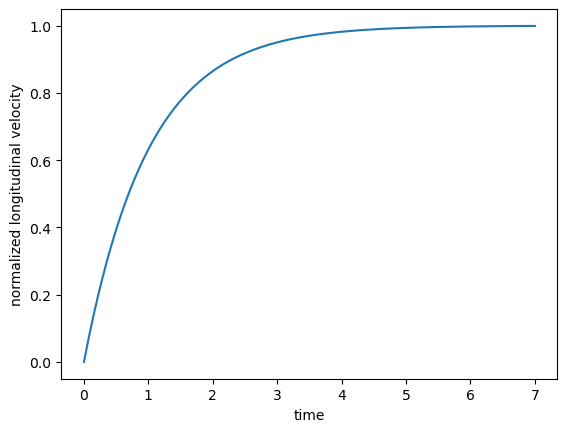

In [9]:
t, y = get_pt1_signal([1.0,1.0])
plt.plot(t, y)
plt.xlabel("time")
plt.ylabel("normalized longitudinal velocity")
plt.savefig("PT1_example")

In [39]:
def find_gain_velocity(long_velocity):
    return long_velocity[len(long_velocity)-1] - long_velocity[0]

In [40]:
def get_velocity_signal(data_path, trip_name, speedup_index, signal_profile):
    data_df = pd.read_csv(os.path.join(data_path, trip_name, "speed_up{index}.csv".format(index = speedup_index)))
    y = data_df[signal_profile["Longitudinal_Velocity"]].values
    t = np.arange(0, len(y))
    return t, y

In [41]:
def get_signals(parameters_df, trip_name,speedup_index):
    t_real, long_velocity = get_velocity_signal(data_path, trip_name=trip_name, speedup_index=speedup_index, signal_profile=signal_profile)
    #project long velocity to start from 0 like pt1
    Kp = find_gain_velocity(long_velocity)
    y_real = (long_velocity - long_velocity[0]) / Kp  
    #get a pt1 signal with the terminal velocity as a gain
    df = parameters_df.iloc[(parameters_df.trip_name.values == trip_name) & (parameters_df.speedup_index.values == speedup_index)]
    t_pt1, y_pt1 = get_pt1_signal([1.0, df.Tp1.values])
    #resample the pt1 model but without the edge noise
    y_pt1 = np.pad(y_pt1, (15, 15), mode='edge')
    padding_length = math.floor(0.15*len(long_velocity))
    y_real = np.pad(y_real, (padding_length, padding_length), mode='edge')
    y_pt1 = signal.resample(y_pt1, 130)
    y_real = signal.resample(y_real, 130)
    padding_length_reduced = 15
    y_pt1 = y_pt1[padding_length_reduced:len(y_pt1)-padding_length_reduced]
    y_real = y_real[padding_length_reduced:len(y_real)-padding_length_reduced]
    t_display = np.arange(0,100)
    return t_display, y_real, y_pt1, Kp

In [42]:
def get_metrics(y_real, y_pt1):
    min_signal = abs(y_pt1-y_real)
    trapz_integral = np.trapz(min_signal, dx=1)
    mae = metrics.mean_absolute_error(y_true=y_real, y_pred=y_pt1)
    mse = metrics.mean_squared_error(y_true=y_real, y_pred=y_pt1)
    return trapz_integral, mae, mse

### Runnables

#### Example

In [32]:
trip_name = "OD_ZJP_G02_20230807_164449__DASy"
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 8]
t_real_norm, y_real_norm, y_pt1_norm, Kp = get_signals(parameters_df=parameters_df, trip_name=trip_name, speedup_index=0)
trapz_integral, mae, mse = get_metrics(y_real_norm, y_pt1_norm)
min_signal_norm = abs(y_pt1_norm-y_real_norm)
plt.plot(t_real_norm, y_real_norm, color='green', label="extracted true speedup")
plt.plot(t_real_norm, y_pt1_norm, color='orange', label="PT1 estimate")
plt.plot(t_real_norm, min_signal_norm, color='lightblue', label="absolute difference function")
plt.xlabel("time")
plt.ylabel("normalized velocity")
plt.title("Example of a Speedup and PT1 estimation")
plt.legend()
plt.ylabel("normalized velocity")
plt.xlabel("normalized time")
plt.savefig(save_path + trip_name + "speedup0_PT1.png")
plt.show()
df = pd.DataFrame(columns=['trapz_integral', 'mae', 'mse'])
df.loc[0] = np.array([trapz_integral, mae, mse]) 
df

IndexError: index 0 is out of bounds for axis 0 with size 0

#### Overall Calculation

In [43]:
accuracy_summary_df = pd.DataFrame(columns=["trip_name","speedup_index","driver_id","velocity_class","highway_driving","K","Tp1","trapz_integral","mae","mse"])
for i in range(parameters_df.shape[0]):
    t_real, y_real, y_pt2, Kp = get_signals(parameters_df=parameters_df, trip_name=parameters_df.trip_name.values[i],speedup_index=parameters_df.speedup_index.values[i])
    trapz_integral, mae, mse = get_metrics(y_real, y_pt2)
    accuracy_summary_df.loc[-1] = [parameters_df.trip_name[i], parameters_df.speedup_index[i], parameters_df.driver_id[i], parameters_df.velocity_class[i], parameters_df.highway_driving[i], 
                                Kp, parameters_df.Tp1[i], trapz_integral, mae, mse]
    accuracy_summary_df.index = accuracy_summary_df.index + 1
accuracy_summary_df

,trip_name,speedup_index,driver_id,velocity_class,highway_driving,K,Tp1,trapz_integral,mae,mse
29128,14_20210726_1627299639420402_CT6_AVT_V3_export,22,2016k_203,low_to_low_speed_up,False,7.3125,2.336457,31.143851,0.311476,0.143730
29127,14_20210726_1627299639420402_CT6_AVT_V3_export,21,2016k_203,low_to_low_speed_up,False,3.0625,8.288454,19.091797,0.190966,0.064511
29126,14_20210726_1627299639420402_CT6_AVT_V3_export,20,2016k_203,low_to_low_speed_up,False,8.6250,6.277712,29.144648,0.291504,0.136796
29125,14_20210726_1627299639420402_CT6_AVT_V3_export,19,2016k_203,zero_to_low_speed_up,False,2.8125,4.284456,34.635719,0.346513,0.170574
29124,14_20210726_1627299639420402_CT6_AVT_V3_export,18,2016k_203,low_to_low_speed_up,False,4.4375,3.875435,25.931719,0.259372,0.110848
...,...,...,...,...,...,...,...,...,...,...
4,10_20180828_1535498983886417_CT6_AVT_V3_export,5,2016k_099,low_to_mid_speed_up,False,4.6250,2.922333,35.438176,0.354438,0.206234
3,10_20180828_1535498983886417_CT6_AVT_V3_export,4,2016k_099,low_to_mid_speed_up,False,4.0000,6.139852,22.272563,0.222780,0.072561
2,10_20180828_1535498983886417_CT6_AVT_V3_export,3,2016k_099,low_to_low_speed_up,False,2.5625,4.055195,18.915579,0.189195,0.051271
1,10_20180828_1535498983886417_CT6_AVT_V3_export,1,2016k_099,low_to_low_speed_up,False,4.3750,3.069036,32.459253,0.324810,0.159164


# Filtering

### Methods

* outlier_filter
    * filters any speedups out of the dataset where Tp1 is too large 
    * Inputs: 
        * speedup_parameters (numpy array) -- parameters [K, Tp1] for all speedups
        * parameters_df (pandas DataFrame): The DataFrame has several columns
            * "trip_name" (string) -- name of the trip that is analyzed
            * "speedup_index" (int) -- index of the speedup that is analyzed within the trip
            * "driver_id" (string) -- name of the driver specified in "ArchiveCheck_update.csv"
            * "velocity_class" (string) -- velocity category extracted as a driving event reason during the Metadata analysis. Possible Categories are:
                * "zero_to_low_speed_up"
                * "zero_to_mid_speed_up"
                * "zero_to_high_speed_up",
                * "low_to_low_speed_up"
                * "low_to_mid_speed_up"
                * "low_to_high_speed_up",
                * "mid_to_mid_speed_up"
                * "mid_to_high_speed_up"
                * "high_to_high_speed_up",
            * "highway_driving" (boolean) -- whether or not any section during the speedup time sequence had a "highway" signal active.
            * "K" (float) -- Control Gain of the transfer function of the PT1 model
            * "Tp1" (float) --  pole of the transfer function of the PT1 model
    * Outputs:
        * speedup_parameters (numpy array) -- parameters [K, Tp1] for all speedups
        * parameters_df (pandas DataFrame) -- The same DataFrame structure as in the input

In [46]:
def outlier_filter(speedup_parameters, parameters_df):
    speedup_parameters = [yi for yi in speedup_parameters if yi[1] < 20.0]
    parameters_df = parameters_df.loc[parameters_df.Tp1 < 20.0]
    return np.array(speedup_parameters), parameters_df

### Runnables

In [52]:
parameters_df.keys()

Index(['trip_name', 'speedup_index', 'driver_id', 'velocity_class',
       'highway_driving', 'K', 'Tp1'],
      dtype='object')

In [47]:
speedup_parameters, parameters_df = outlier_filter(speedup_parameters, parameters_df)

# Representations

In [48]:
def plot_pt1(parameters, color='blue'):
    K = parameters[0]
    Tp1 = parameters[1]
    PT1 = signal.lti([K],[Tp1,1])
    t, y = signal.step(PT1)
    plt.plot(t, y, color=color)

## Overall

### Histograms

#### Tp1 parameter

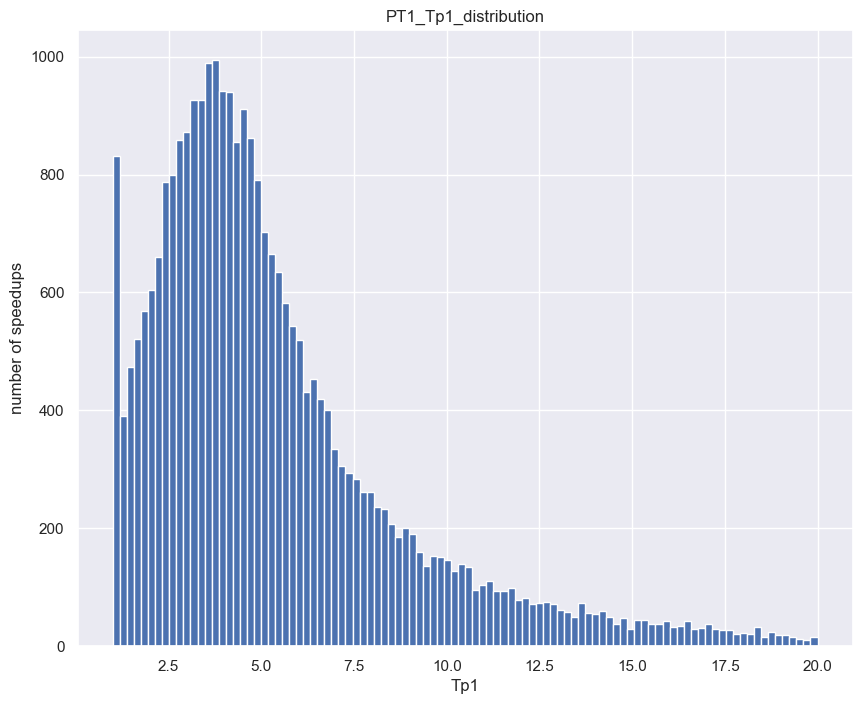

In [49]:
plt.hist(parameters_df.Tp1.values, bins=100)
plt.xlabel("Tp1")
plt.ylabel("number of speedups")
plt.title("PT1_Tp1_distribution")
plt.savefig(save_path + "PT1_Tp1_distribution.png")
plt.show()

#### Loss

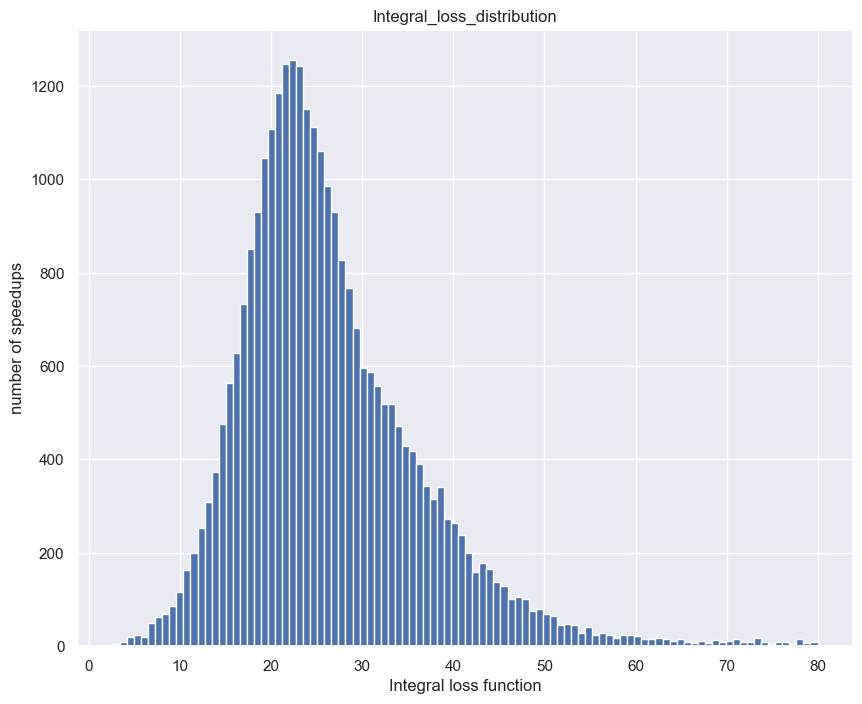

In [56]:
accuracy_summary_df = accuracy_summary_df.loc[accuracy_summary_df.trapz_integral.values < 80]
plt.hist(accuracy_summary_df.trapz_integral.values, bins=100)
plt.xlabel("Integral loss function")
plt.ylabel("number of speedups")
plt.title("Integral_loss_distribution")
plt.savefig(save_path + "Integral_loss_distribution.png")
plt.show()

## Per Driver

In [ ]:
#drivers ranked by the number of speedups
drivers_ranked = ["2016k_185", "2016k_110", "2016k_114", "2016k_137", "2016k_148", "2016k_097", "2016k_107", "2016k_104", "2016k_209"
    "2016k_160", "2016k_119", "2016k_123", "2016k_203", "2016k_103", "2016k_121", "2016k_146", "2016k_127", "2016k_156", "2016k_176", 
    "2016k_140", "2016k_131", "2016k_112", "2016k_161", "2016k_178","2016k_101", "2016k_133", "2016k_194", "2016k_198", "2016k_186",
    "2016k_pilot_005","2016k_099"]

### Boxplots

In [ ]:
sns.catplot(data=parameters_df, y="driver_id", x="Tp1", kind="box", height=8, aspect=2)
plt.title("Tp1 parameter distribution compared by driver")
plt.savefig(save_path + "box_plot_comparing_drivers_Tp1_from_PT1_model.png")
plt.show()

## Per Velocity Class

In [ ]:
velocity_classes = ["zero_to_low_speed_up", "zero_to_mid_speed_up", "zero_to_high_speed_up",
                "low_to_low_speed_up", "low_to_mid_speed_up", "low_to_high_speed_up",
                "mid_to_mid_speed_up", "mid_to_high_speed_up", "high_to_high_speed_up",
                ]

### Boxplots

In [ ]:
sns.catplot(data=parameters_df, y="velocity_class", x="Tp1", kind="box", height=8, aspect=2)
plt.title("Tp1 parameter distribution compared by velocity class")
plt.savefig(save_path + "box_plot_comparing_velocity_classes_Tp1_from_PT1_model.png")
plt.show()

## Per Driver Per Velocity Class

### Boxplots

In [ ]:
for driver in drivers_ranked:
    driver_df = parameters_df.loc[parameters_df.driver_id == driver]
    sns.catplot(data=driver_df, y="velocity_class", x="Tp1", kind="box", height=8, aspect=2)
    plt.title("Tp1 parameter distribution compared {d} by velocity classes".format(d = driver))
    plt.savefig(save_path + "box_plot_" + driver + "_Tp1.png")
    plt.show()